In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [15]:
df = pd.read_csv('Gold2.csv')
df['decision'] = 'Hold'

short_window = 5
long_window = 15

# Calculate short-term and long-term moving averages
df['SMA_short'] = df['Close/Last'].rolling(window=short_window).mean()
df['SMA_long'] = df['Close/Last'].rolling(window=long_window).mean()


df.dropna(inplace=True)

df['PriceChange'] = df['Close/Last'].pct_change().fillna(0)
df['Action'] = 0  # 0: Hold, 1: Buy, 2: Sell

In [16]:
# Define labels for supervised learning
for i in range(len(df)):
    if df['Close/Last'].iloc[i] < df['SMA_short'].iloc[i]:
        df.loc[df.index[i], 'Action'] = 1  # Buy
    elif df['Close/Last'].iloc[i] > df['SMA_long'].iloc[i]:
        df.loc[df.index[i], 'Action'] = 2  # Sell

In [17]:
# Split data into training and test sets
split_ratio = 0.8
train_size = int(len(df) * split_ratio)
train_data = df[:train_size]
test_data = df[train_size:]

In [18]:
class TradingDataset(Dataset):
    def __init__(self, data, sequence_length=10):
        self.data = data
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data) - self.sequence_length

    def __getitem__(self, idx):
        seq = self.data.iloc[idx:idx + self.sequence_length]
        features = seq[['Close/Last', 'SMA_short', 'SMA_long', 'PriceChange']].values
        action = seq['Action'].iloc[-1]
        return torch.tensor(features, dtype=torch.float32), torch.tensor(action, dtype=torch.long)

In [19]:
sequence_length = 10
train_dataset = TradingDataset(train_data, sequence_length=sequence_length)
test_dataset = TradingDataset(test_data, sequence_length=sequence_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [20]:
class DecisionTransformer(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, n_heads, n_layers):
        super(DecisionTransformer, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=n_heads, dim_feedforward=hidden_dim)
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=n_layers)
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = x.permute(1, 0, 2)
        x = self.encoder(x)
        x = x.mean(dim=0)
        x = self.fc(x)
        return x

In [21]:
input_dim = 4
output_dim = 3
hidden_dim = 64
n_heads = 4
n_layers = 2

In [22]:
model = DecisionTransformer(input_dim=input_dim, output_dim=output_dim, hidden_dim=hidden_dim, n_heads=n_heads, n_layers=n_layers)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [23]:
# Training loop
epochs = 100
train_losses = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    for features, actions in train_loader:
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, actions)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    train_losses.append(epoch_loss / len(train_loader))
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(train_loader):.4f}")

Epoch 1/100, Loss: 1.0027
Epoch 2/100, Loss: 0.9750
Epoch 3/100, Loss: 0.9741
Epoch 4/100, Loss: 0.9748
Epoch 5/100, Loss: 0.9744
Epoch 6/100, Loss: 0.9743
Epoch 7/100, Loss: 0.9736
Epoch 8/100, Loss: 0.9745
Epoch 9/100, Loss: 0.9740
Epoch 10/100, Loss: 0.9733
Epoch 11/100, Loss: 0.9727
Epoch 12/100, Loss: 0.9725
Epoch 13/100, Loss: 0.9739
Epoch 14/100, Loss: 0.9730
Epoch 15/100, Loss: 0.9737
Epoch 16/100, Loss: 0.9723
Epoch 17/100, Loss: 0.9728
Epoch 18/100, Loss: 0.9731
Epoch 19/100, Loss: 0.9729
Epoch 20/100, Loss: 0.9717
Epoch 21/100, Loss: 0.9731
Epoch 22/100, Loss: 0.9732
Epoch 23/100, Loss: 0.9723
Epoch 24/100, Loss: 0.9719
Epoch 25/100, Loss: 0.9733
Epoch 26/100, Loss: 0.9715
Epoch 27/100, Loss: 0.9727
Epoch 28/100, Loss: 0.9700
Epoch 29/100, Loss: 0.9724
Epoch 30/100, Loss: 0.9695
Epoch 31/100, Loss: 0.9559
Epoch 32/100, Loss: 0.9715
Epoch 33/100, Loss: 0.9556
Epoch 34/100, Loss: 0.9684
Epoch 35/100, Loss: 0.9550
Epoch 36/100, Loss: 0.9587
Epoch 37/100, Loss: 0.9539
Epoch 38/1

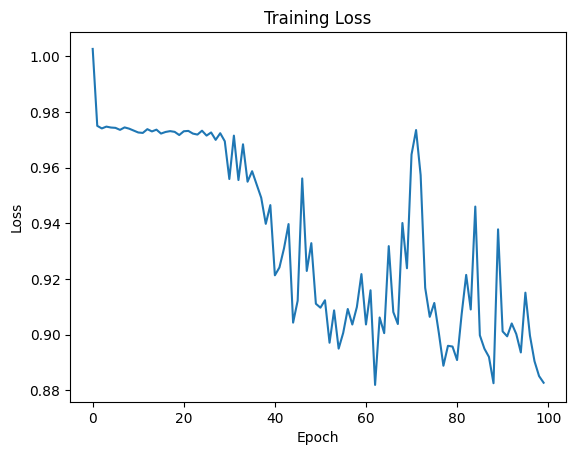

In [24]:
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [25]:
model.eval()
balance = 10000
owned_gold = 0
test_features = test_data[['Close/Last', 'SMA_short', 'SMA_long', 'PriceChange']].values

for i in range(sequence_length, len(test_features)):
    seq = torch.tensor(test_features[i-sequence_length:i], dtype=torch.float32).unsqueeze(0)
    with torch.no_grad():
        action = torch.argmax(model(seq)).item()

    current_price = test_data['Close/Last'].iloc[i]

    if action == 1 and balance > 0:  # Buy
        owned_gold += balance / current_price
        balance = 0

    elif action == 2 and owned_gold > 0:  # Sell
        balance += owned_gold * current_price
        owned_gold = 0


if owned_gold > 0:
    balance += owned_gold * test_data['Close/Last'].iloc[-1]

print(f"Final balance: ${balance:.2f}")


Final balance: $11936.55
